# **Weather Prediction**

## [Link to dataset](https://www.kaggle.com/datasets/ananthr1/weather-prediction)

**Dataset has following attributes:**
* date: date with the YYYY-MM-DD format
* precipitation: The amount of water which falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle
* temp_max: Maximum Temperature 
* temp_min: Minimum Temperature
* wind: Wind speed
* **weather: Target variable, the weather of that date**

**Contents:**
1. [Import libraries and data](#section-one)
1. [Exploratory Data Analysis](#section-two)
1. [Overcoming challenges](#section-three)
1. [Preparation and implementation of ML models](#section-four)
1. [Results evaluation](#section-five)

<a id=section-one></a>
# <span style="color:#409996;font-weight:600;font-size:30px;font-style:sans-serif;">1. Import libraries and data</span>

In [97]:
#import data manipulation and visualisation libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

#attributes normalisation
from scipy.special import boxcox1p

#encoder
from sklearn import preprocessing

# Standardize the data
from sklearn.preprocessing import StandardScaler

#rebalancing target variable
from imblearn.over_sampling import RandomOverSampler

#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#other libraries
import math
from collections import Counter
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

#set no randomness
np.random.seed(0)

In [98]:
#load data from csv file
dataset = pd.read_csv('./../data/seattle-weather.csv')

<a id=section-two></a>
# <span style="color:#409996;font-weight:600;font-size:30px;font-style:sans-serif;">2. Exploratory Data Analysis</span>

We perform Exploratory Data Analysis or EDA to:
1. Understand dataset variables
1. Clean dataset
1. Plot dataset variables
1. Analyze relationships between variables

**2.1 Understanding dataset variables**

In [99]:
#view first 5 rows
dataset.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [100]:
#number of rows and attributes
dataset.shape

(1461, 6)

In [101]:
#names of all present attributes in the dataset
dataset.columns

Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')

In [102]:
#datatypes of all present attributes in the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [103]:
#number of distinct elements in each attribute
dataset.nunique(axis=0)

date             1461
precipitation     111
temp_max           67
temp_min           55
wind               79
weather             5
dtype: int64

In [104]:
#statistic metrics for continuous variables without scientific notation
dataset.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [105]:
#check discrete variables 
print("Unique values of weather:", dataset.weather.unique())

Unique values of weather: ['drizzle' 'rain' 'sun' 'snow' 'fog']


**2.2 Cleaning dataset**

In [106]:
#feature selection = drop redundant attributes
dataset = dataset.drop(labels=['date'], axis=1)

In [107]:
#check for missing values
print("Missing values in the dataset:\n\n",dataset.isna().sum())

Missing values in the dataset:

 precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64


**2.3 Plot dataset attributes**

Let's plot possible features(attributes that can be useful to predict value of target variable) into boxplots(since they are continuous variables) to see the distribution of values.

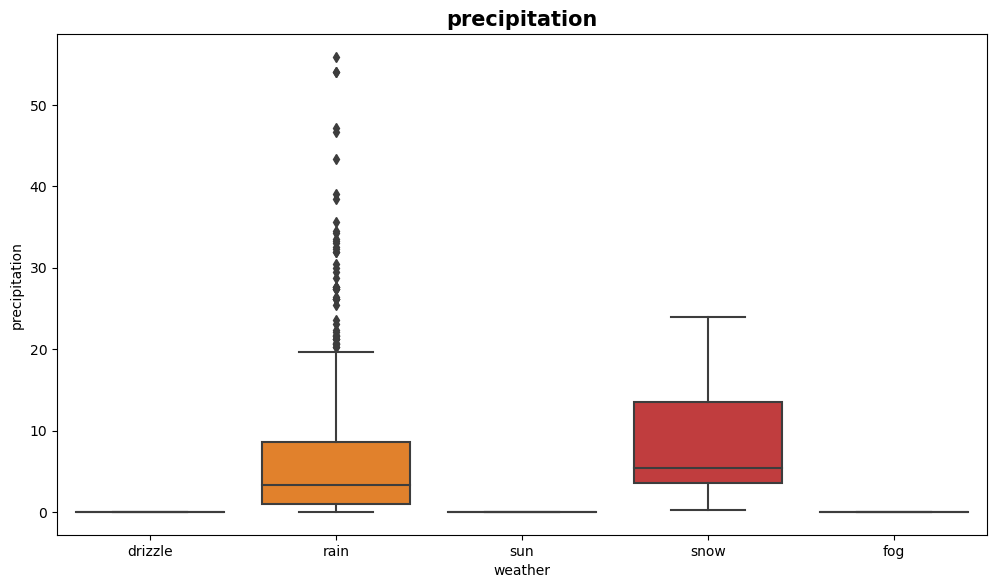

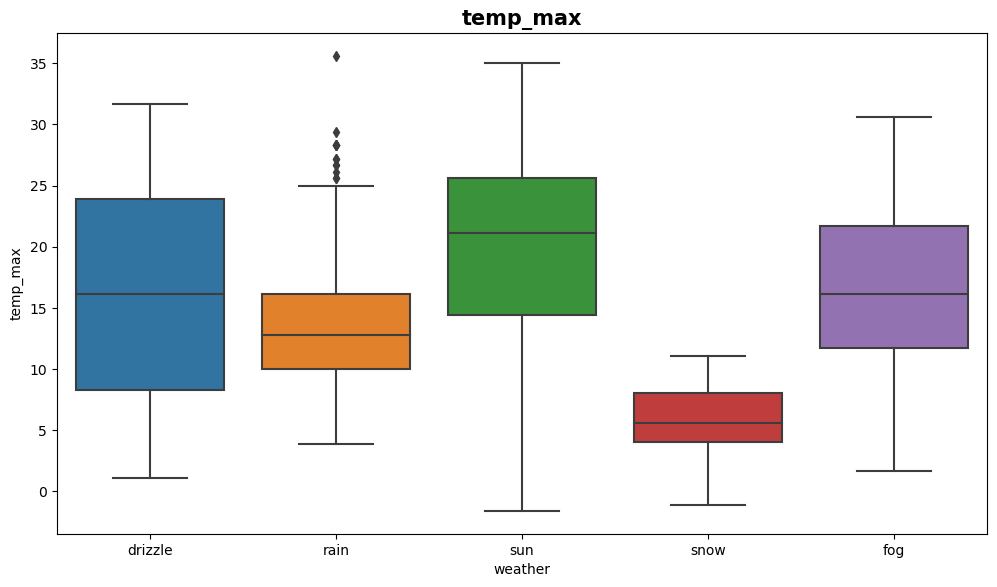

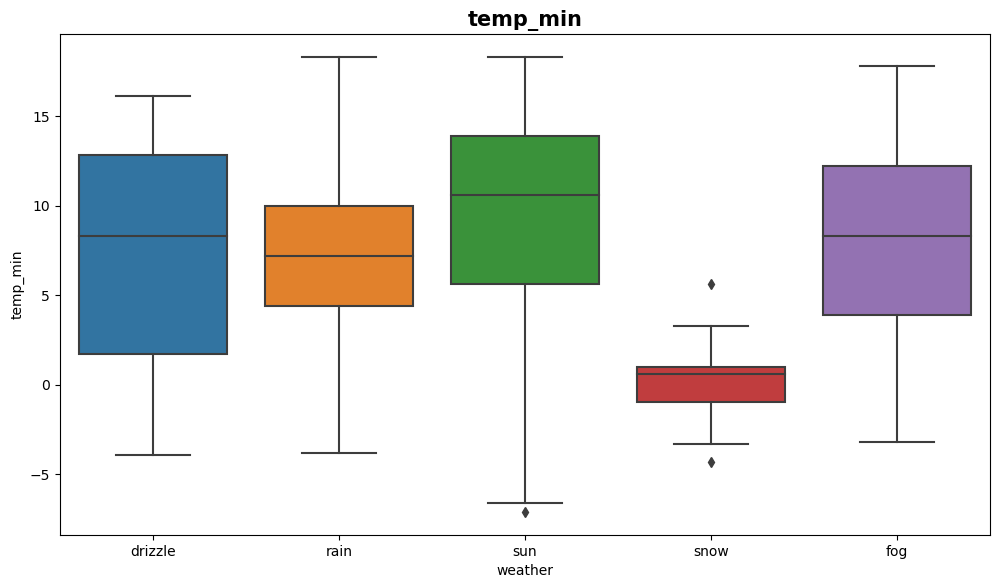

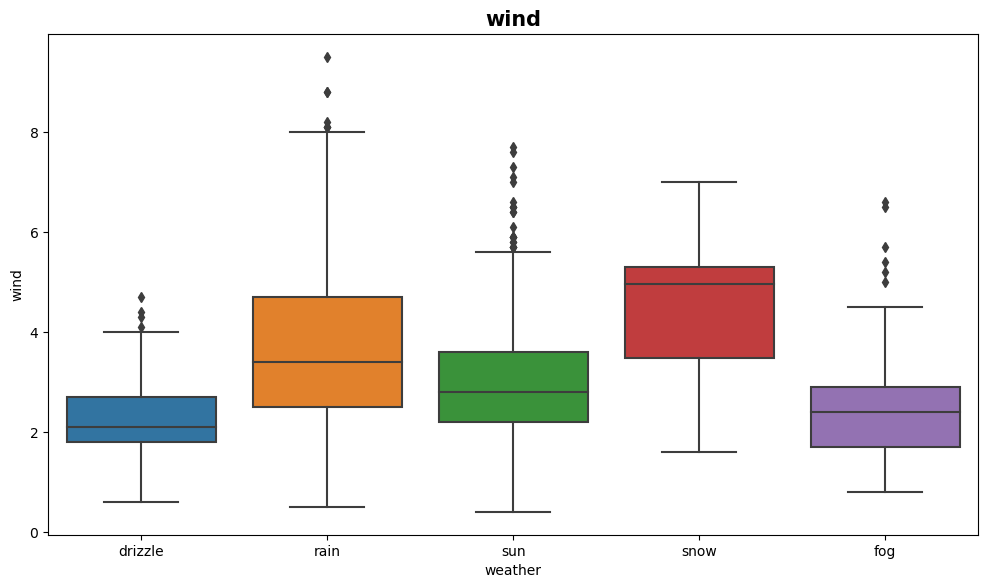

In [108]:
#create a list of numerical features and plot them
list_of_num_features = dataset[['precipitation', 'temp_max', 'temp_min', 'wind']]  

for feature in list_of_num_features:
    plt.figure(figsize=(12,6.5)) 
    plt.title(feature, fontsize=15, fontweight='bold', ha='center')
    ax = sns.boxplot(x = dataset['weather'], y = list_of_num_features[feature], data = dataset)
    #add labels to each bar
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

Since this dataset contains ***Outliers ,it will be removed***,to make data set more even.

In [109]:
temp = dataset.shape[0]

#set boundaries for variables to remove outliers in data.
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3-Q1
dataset = dataset[~((dataset< (Q1-1.5*IQR)) | (dataset>(Q3+1.5*IQR))).any(axis=1)]
print(str(temp - dataset.shape[0]) + ' outliers removed')
print("New dataset shape:", dataset.shape)

Removed 228 outliers
New dataset shape: (1233, 5)


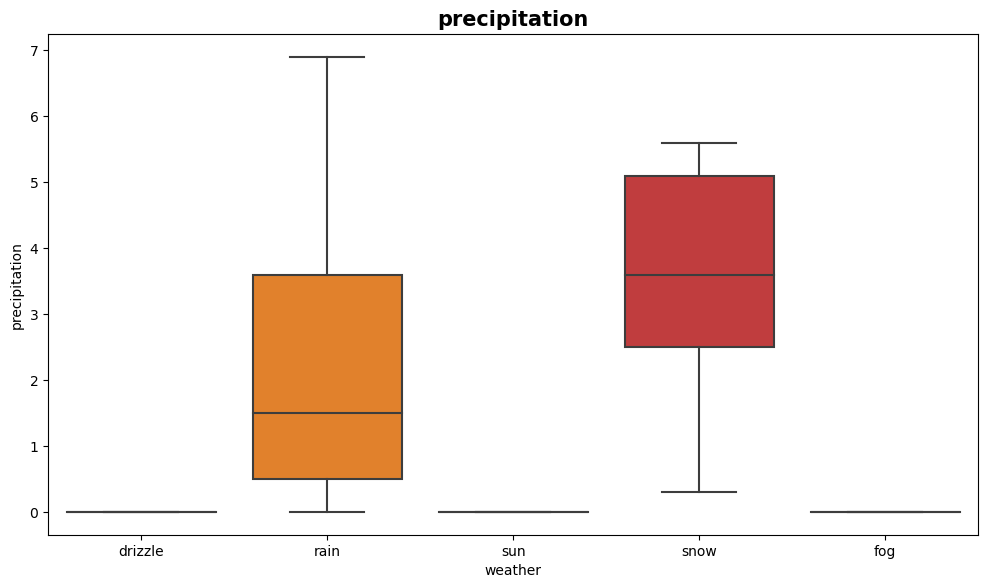

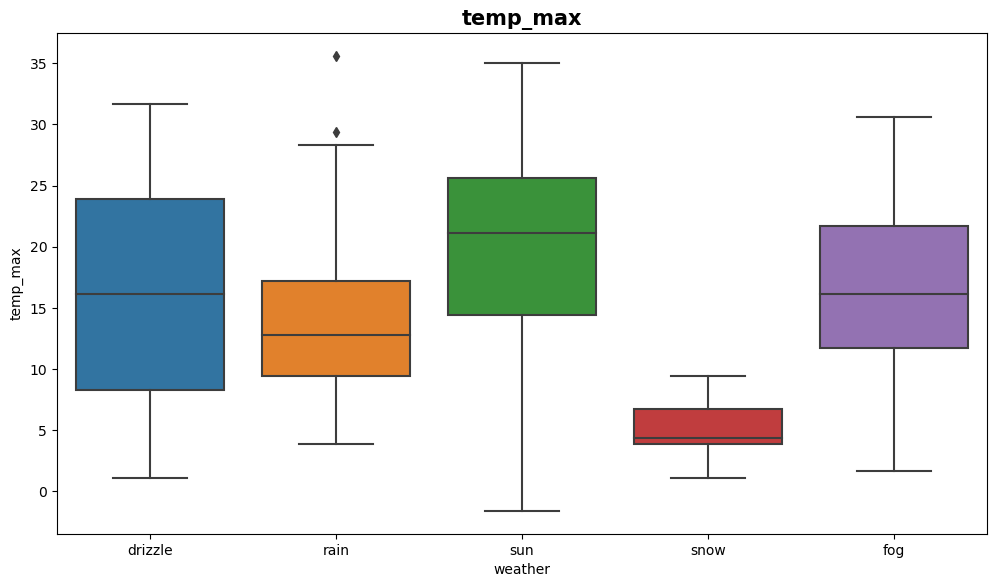

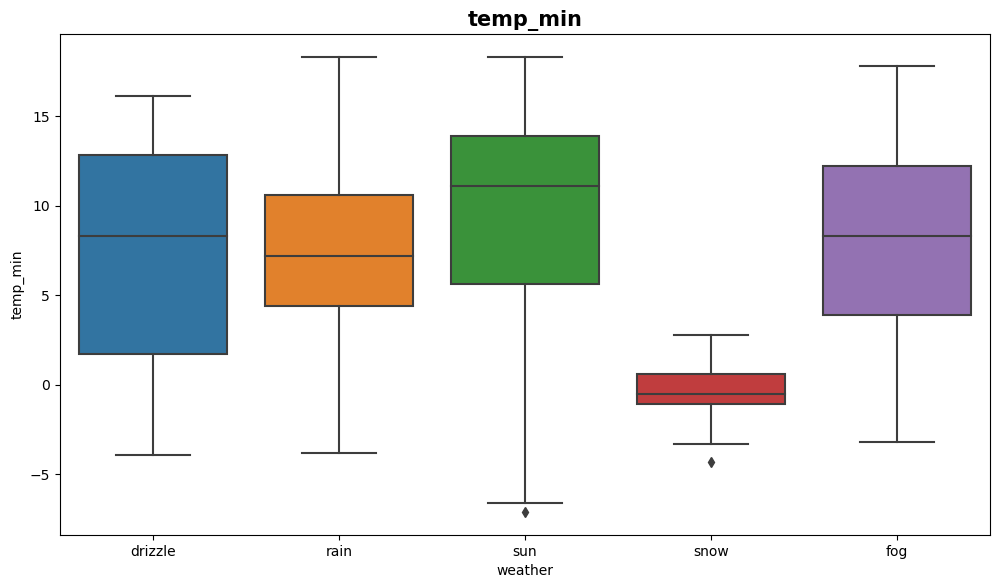

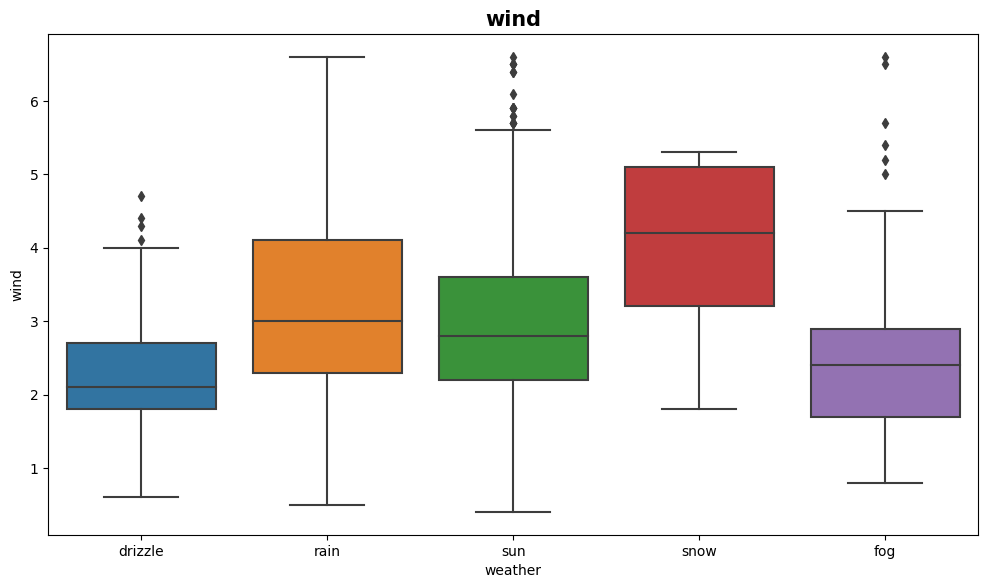

In [110]:
#plot the dataset again after removinf outliers
list_of_num_features = dataset[['precipitation', 'temp_max', 'temp_min', 'wind']]  

for feature in list_of_num_features:
    plt.figure(figsize=(12,6.5)) 
    plt.title(feature, fontsize=15, fontweight='bold', ha='center')
    ax = sns.boxplot(x = dataset['weather'], y = list_of_num_features[feature], data = dataset)
    #add labels to each bar
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

All atrributes clearly don't follow normal distribution and thus we have to achieve normal distribution. This will be solved using standard scaler later on


Last attribute to plot is the target variable, weather. As we can notice, target variable is heavily imbalanced, which means that further used ML models will tend to prefer target variable with value 'sun' and 'rain' over others. As we want our models to be useful on different, unseen datasets as well, we have to deal with this problem later on.

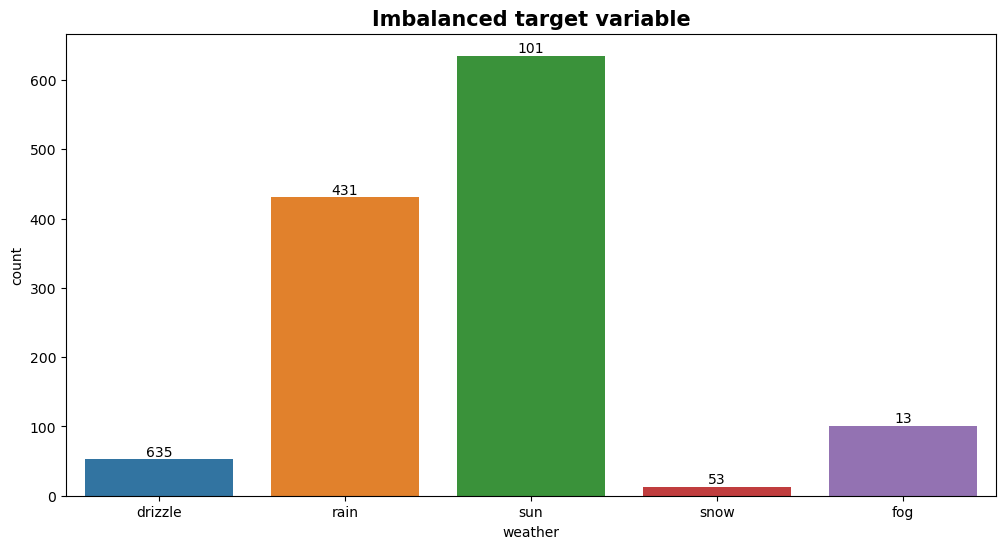

In [111]:
#plotting 'Exited' = target variable
plt.figure(figsize=(12,6))
plt.title("Imbalanced target variable", fontsize=15, fontweight='bold', ha='center')
ax = sns.countplot(x=dataset['weather'], data=dataset)

#add labels to each bar
abs_values = dataset['weather'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values) 

#show the plot
plt.show()

**2.4 Analyzing relationships between variables**

We would also like to check, whether there are any significant (<= -0.70, >= 0.70) correlations between all features.

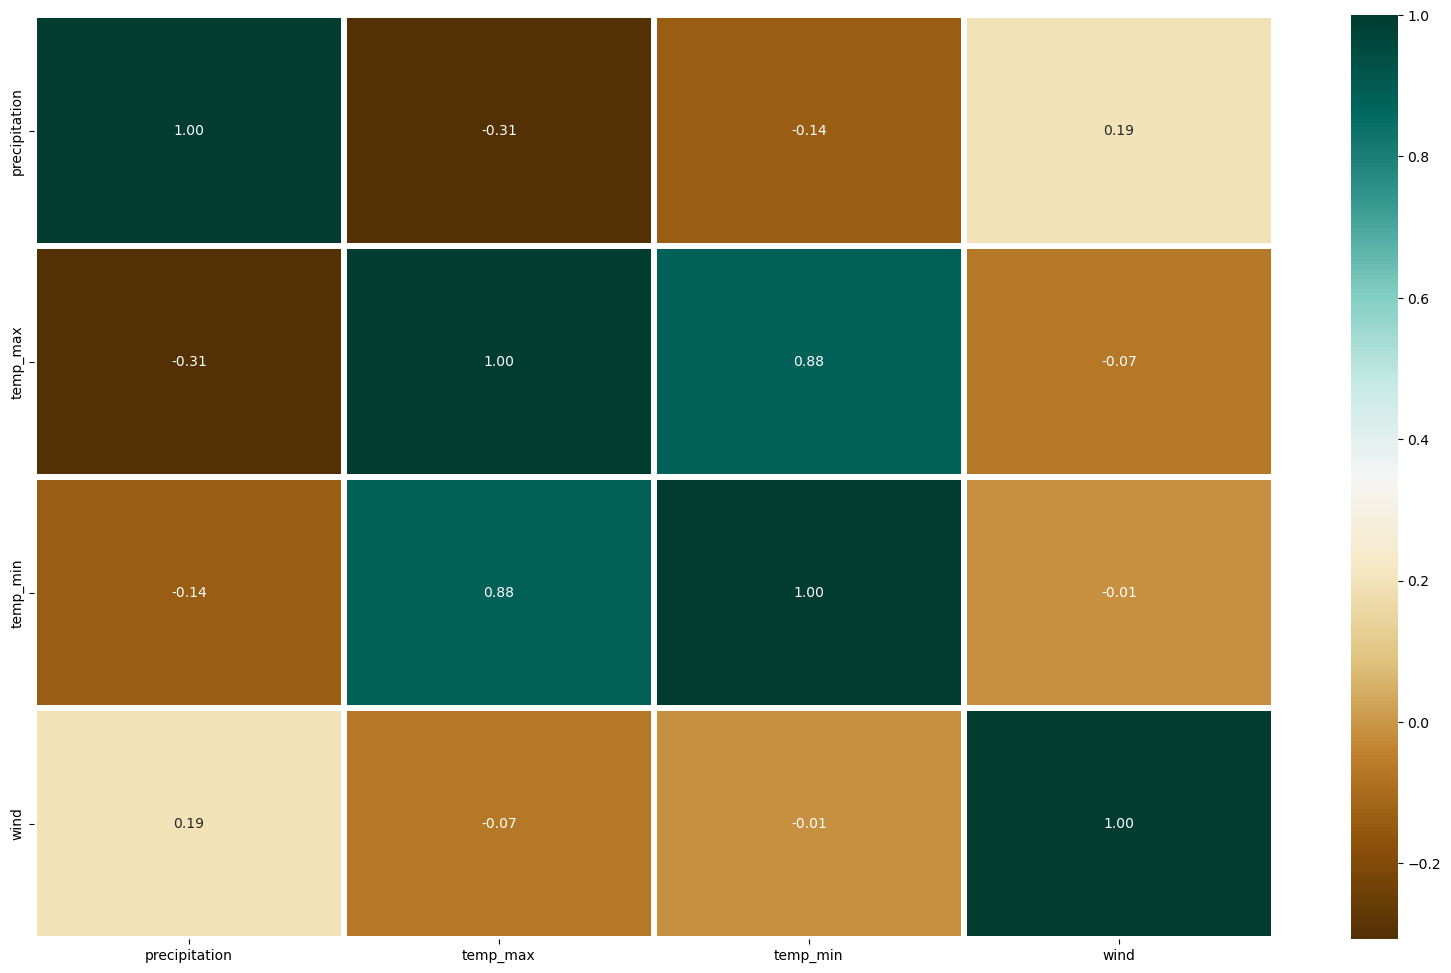

In [112]:
# plotting correlation matrix to notice relationships or lack of it between variables
corr = dataset.corr()

plt.figure(figsize = (20, 12))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = 4, annot = True, fmt = ".2f", cmap="BrBG")
plt.show()

The highest correlations are between temp_max and temp_min (0.88), which causes multicollinearity. This reduces the precision of the estimated coefficients, which weakens the statistical power of the model. To fix this problem, we can either remove temp_max or temp_min but doing this means one important feature for weather forcasting will be lost. Thus, we will calculate the average temperature of temp_max, temp_min and make it a feature then drop these two features.

In [113]:
# Add a 'temp_avg' column and drop 'temp_min' and 'temp_max'
dataset['temp_avg'] = dataset[['temp_max', 'temp_min']].mean(axis=1)
dataset = dataset.drop(columns=['temp_max', 'temp_min'])
temp = dataset['weather']
dataset = dataset.drop(columns=['weather'])
dataset['weather'] = temp
dataset

,precipitation,wind,temp_avg,weather
0,0.0,4.7,8.90,drizzle
2,0.8,2.3,9.45,rain
4,1.3,6.1,5.85,rain
5,2.5,2.2,3.30,rain
6,0.0,2.3,5.00,rain
...,...,...,...,...
1455,0.0,2.5,2.20,sun
1457,1.5,1.3,3.35,rain
1458,0.0,2.6,3.90,fog
1459,0.0,3.4,2.30,sun


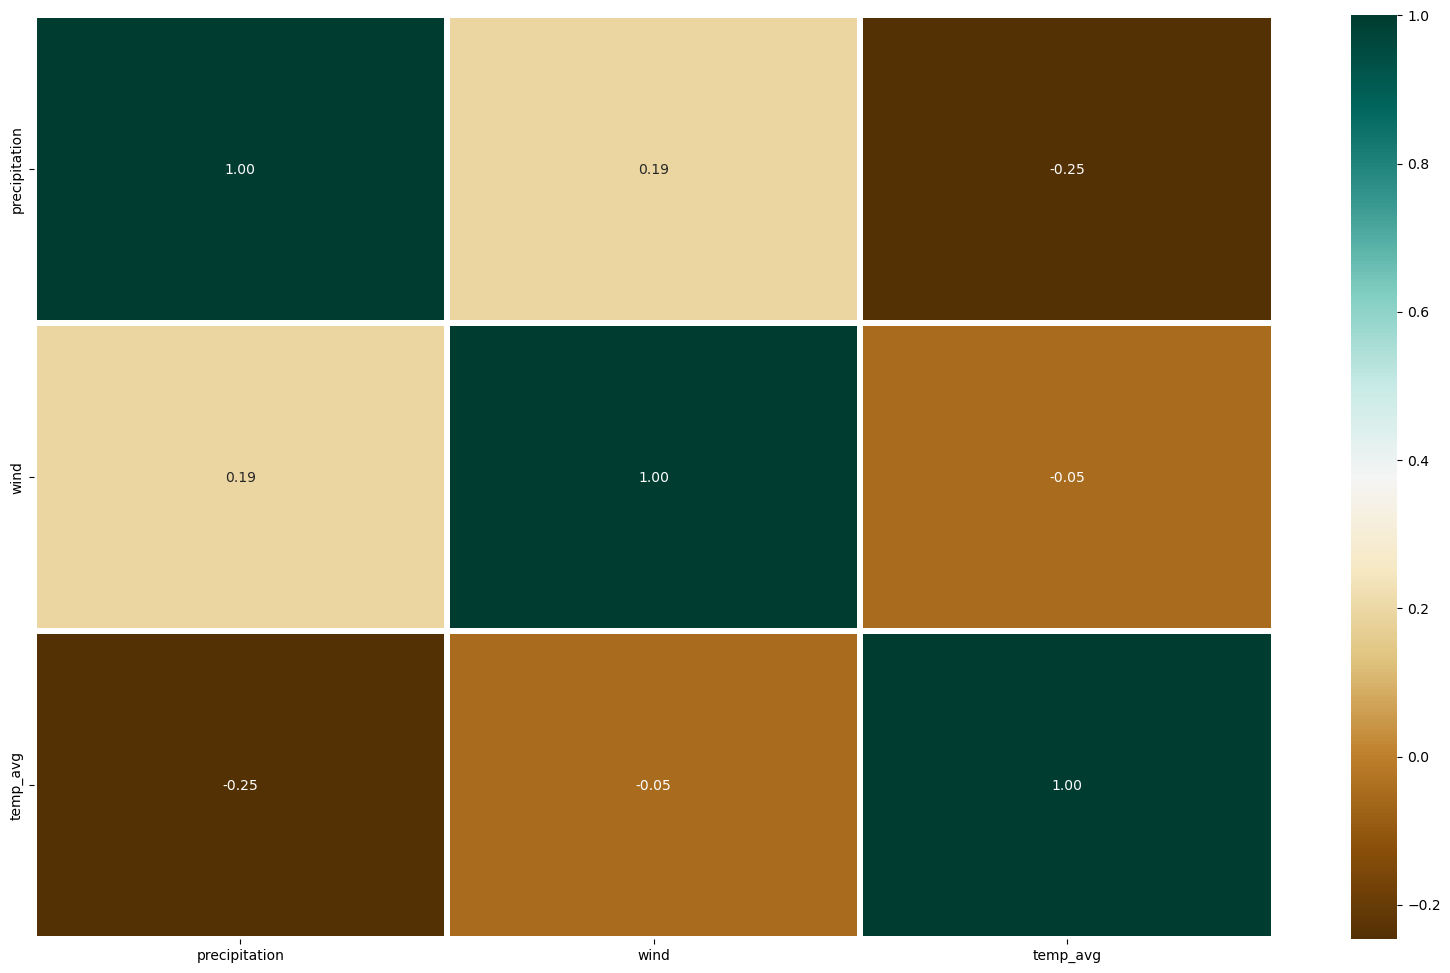

In [114]:
# plotting correlation matrix again to check for significant correlations
corr = dataset.corr()

plt.figure(figsize = (20, 12))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = 4, annot = True, fmt = ".2f", cmap="BrBG")
plt.show()

After transforming, we can see there are no significant (<= -0.70, >= 0.70) correlations between all features.

**From the information we've learned about our dataset, we have to deal with the following challenges:**

* We need to transform all categorical attributes into numerical so that models can mostly work only with numerical inputs.
* The target variable "weather" is highly unbalanced, it needs to be balanced in order to be able to implement various machine learning models with fair, unbiased results.


<a id=section-three></a>
# <span style="color:#409996;font-weight:600;font-size:30px;font-style:sans-serif;">3. Overcoming challenges</span>

**3.1. Transformation of categorical attributes**

First of all, let's transform categorical attributes into numerical using LabelEncoder.

In [115]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'weather'.
dataset['weather']= label_encoder.fit_transform(dataset['weather'])
dataset.head()

,precipitation,wind,temp_avg,weather
0,0.0,4.7,8.90,0
2,0.8,2.3,9.45,2
4,1.3,6.1,5.85,2
5,2.5,2.2,3.30,2
6,0.0,2.3,5.00,2


In [116]:
# inverse transform
label_encoder.inverse_transform([0, 1, 2, 3, 4])

array(['drizzle', 'fog', 'rain', 'snow', 'sun'], dtype=object)

##### Classes after being transformed:
* 0: drizzle
* 1: fog
* 2: rain
* 3: snow
* 4: sun

**3.2. Balancing the target variable**

Now we can advance to the imbalanced target variable we have to deal with. We will use oversampling strategy using the RandomOverSampler class, thus we will generate same numbers of rows for all values of target variable weather, therefore we will get the same number of rows for all values of target variable. If we would not dealt with the imbalanced target variable, machine learning models would then prefer (would be biased toward) dominant classes.

In [117]:
#balancing the target variable
columns = ['precipitation', 'wind', 'temp_avg']
y = dataset['weather'] #prior target variable
X = dataset[columns]  #prior features

ros = RandomOverSampler(sampling_strategy='not majority')
X_train_balanced, y_train_balanced = ros.fit_resample(X, y) #y_train as balanced target variable
print(f"Imbalanced target class: {(y)}\n\nBalanced target class: {Counter(y_train_balanced)}\n")
print(X_train_balanced.shape[0] - dataset.shape[0], 'new random picked points')

Imbalanced target class: 0       0
2       2
4       2
5       2
6       2
       ..
1455    4
1457    2
1458    1
1459    4
1460    4
Name: weather, Length: 1233, dtype: int32

Balanced target class: Counter({0: 635, 2: 635, 4: 635, 3: 635, 1: 635})

1942 new random picked points


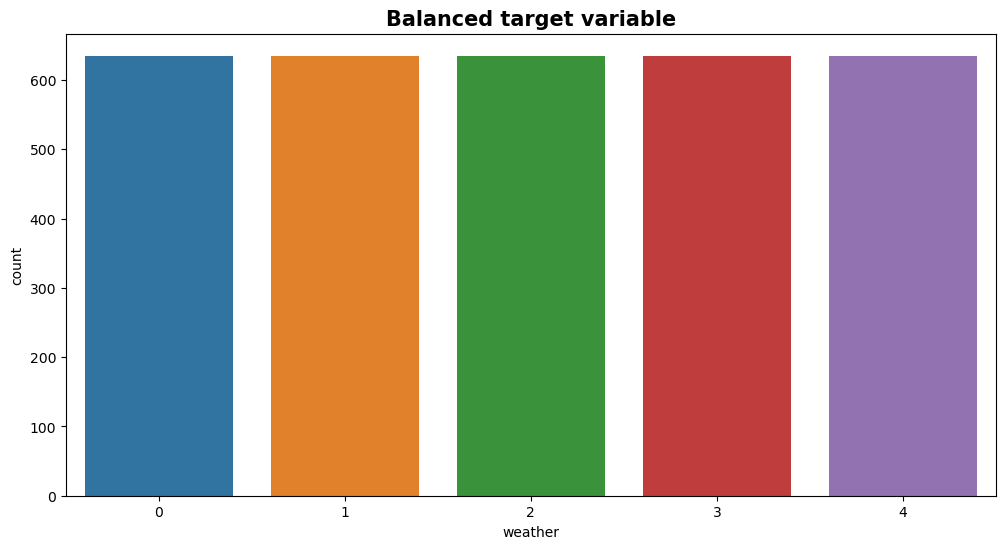

In [118]:
#plot the balanced target variable
plt.figure(figsize=(12,6))
plt.title("Balanced target variable", fontsize=15, fontweight='bold', ha='center')
ax = sns.countplot(x=y_train_balanced, data=dataset)
plt.show()

<a id=section-four></a>
# <span style="color:#409996;font-weight:600;font-size:30px;font-style:sans-serif;">4. Preparation and implementation of ML models</span>

# <span style="color:#409996;font-weight:600;font-size:20px;font-style:sans-serif;">4.1. Preparation </span>

In [119]:
#preparation of train and test data for ML models
X_train,X_test,y_train,y_test = train_test_split(X_train_balanced, y_train_balanced,test_size=0.3, random_state = 1) #70 % of train data, 30 % of test data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2222, 3), (953, 3), (2222,), (953,))

In [120]:
# Standardization to achive standard normal distribution
sc = StandardScaler()
# Standardize the training dataset
X_train_transformed = pd.DataFrame(sc.fit_transform(X_train), index = X_train.index, columns = X_train.columns)
# Standardize the testing dataset
X_test_transformed = pd.DataFrame(sc.transform(X_test), index = X_test.index, columns = X_test.columns)

# <span style="color:#409996;font-weight:600;font-size:20px;font-style:sans-serif;">4.2. Model implementation</span>

**Default K-Nearest Neighbors**

In [121]:
# Create Default K-Nearest Neighbors model
knn = KNeighborsClassifier()
# Create Default K-Nearest Neighbors model
knn.fit(X_train_transformed, y_train)
#Predict the response for test dataset
y_pred_knn = knn.predict(X_test_transformed)

#evaluation
default_knn_accuracy = accuracy_score(y_test, y_pred_knn)
default_knn_precision = precision_score(y_test, y_pred_knn, average='macro')
default_knn_recall = recall_score(y_test, y_pred_knn, average='macro')
default_knn_f1 = f1_score(y_test, y_pred_knn, average='macro')

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       184
           1       0.65      0.94      0.76       191
           2       0.98      0.77      0.87       191
           3       0.99      1.00      0.99       179
           4       0.81      0.41      0.55       208

    accuracy                           0.81       953
   macro avg       0.84      0.82      0.81       953
weighted avg       0.84      0.81      0.80       953

Accuracy Score : 0.811
Precision Score : 0.837
Recall Score : 0.822
F-Score : 0.806


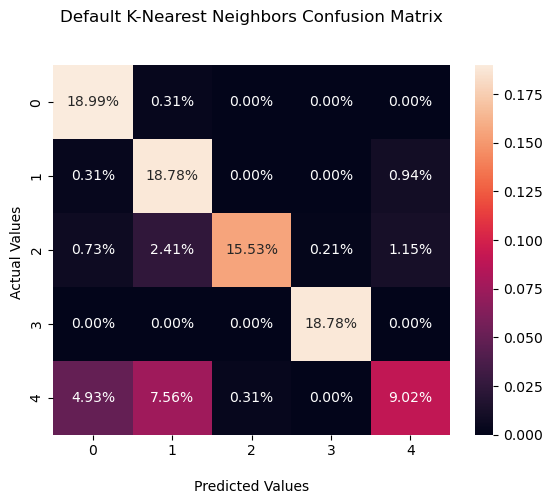

In [122]:
#evaluation of Default K-Nearest Neighbors: metrics pivot chart
print(classification_report(y_test, y_pred_knn))

print('Accuracy Score : ' + str(round(default_knn_accuracy,3)))
print('Precision Score : ' + str(round(default_knn_precision,3)))
print('Recall Score : ' + str(round(default_knn_recall,3)))
print('F-Score : ' + str(round(default_knn_f1,3)))

cf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
ax = sns.heatmap(cf_matrix_knn/np.sum(cf_matrix_knn), annot=True, fmt='.2%')

ax.set_title('Default K-Nearest Neighbors Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**K-Nearest Neighbors with hyperparameter tuning**

Important hyperparameters of KNeighborsClassifier function:
* n_neighbors
* weights
* metric

In [123]:
#hyperparameter tuning of K-Nearest Neighbors (parameters must be of data type list)
knn_params = {'n_neighbors': list(range(1,20)), 
              'weights' : ['uniform','distance'],
              'metric' : ['minkowski','euclidean','manhattan']} 
knn_model_tuning = GridSearchCV(KNeighborsClassifier(), param_grid = knn_params, n_jobs=-1)
grid_knn_metrics = knn_model_tuning.fit(X_train_transformed, y_train)

#Predict values based on new parameters
y_knn_pred_metrics = grid_knn_metrics.predict(X_test_transformed)

# the best parameters of K-NN
print('Most suitable parameters for K-Nearest Neighbors: ' + str(grid_knn_metrics.best_params_) + '\n')

#evaluation
tuned_knn_accuracy = accuracy_score(y_test, y_knn_pred_metrics)
tuned_knn_precision = precision_score(y_test, y_knn_pred_metrics, average='macro')
tuned_knn_recall = recall_score(y_test, y_knn_pred_metrics, average='macro')
tuned_knn_f1 = f1_score(y_test, y_knn_pred_metrics, average='macro')

Most suitable parameters for K-Nearest Neighbors: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}



              precision    recall  f1-score   support

           0       0.85      0.98      0.91       184
           1       0.82      0.97      0.89       191
           2       0.98      0.88      0.93       191
           3       0.99      1.00      1.00       179
           4       0.88      0.68      0.76       208

    accuracy                           0.90       953
   macro avg       0.90      0.90      0.90       953
weighted avg       0.90      0.90      0.89       953

Accuracy Score : 0.897
Precision Score : 0.904
Recall Score : 0.903
F-Score : 0.898


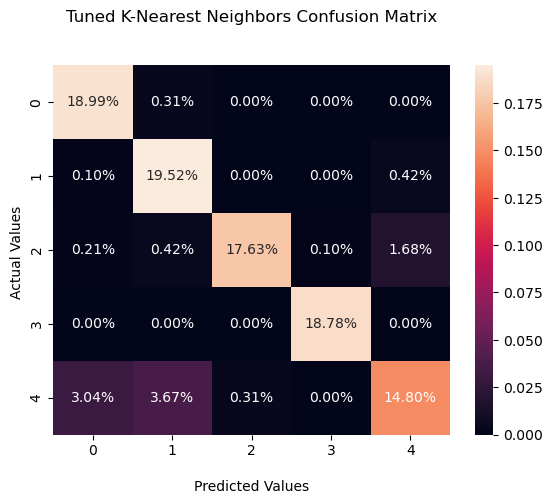

In [124]:
#evaluation of Tuned K-Nearest Neighbors: metrics pivot chart
print(classification_report(y_test, y_knn_pred_metrics))

print('Accuracy Score : ' + str(round(tuned_knn_accuracy,3)))
print('Precision Score : ' + str(round(tuned_knn_precision,3)))
print('Recall Score : ' + str(round(tuned_knn_recall,3)))
print('F-Score : ' + str(round(tuned_knn_f1,3)))

cf_matrix_knn = confusion_matrix(y_test, y_knn_pred_metrics)
ax = sns.heatmap(cf_matrix_knn/np.sum(cf_matrix_knn), annot=True, fmt='.2%')

ax.set_title('Tuned K-Nearest Neighbors Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Default Decision Tree**

In [125]:
# Create Default Decision Tree model
dt = DecisionTreeClassifier(random_state = 0)
# Create Default Decision Tree model
dt.fit(X_train_transformed, y_train)
#Predict the response for test dataset
y_pred_dt = dt.predict(X_test_transformed)

#evaluation
default_dt_accuracy = accuracy_score(y_test, y_pred_dt)
default_dt_precision = precision_score(y_test, y_pred_dt, average='macro')
default_dt_recall = recall_score(y_test, y_pred_dt, average='macro')
default_dt_f1 = f1_score(y_test, y_pred_dt, average='macro')

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       184
           1       0.83      0.98      0.90       191
           2       0.97      0.90      0.93       191
           3       0.97      1.00      0.99       179
           4       0.92      0.67      0.78       208

    accuracy                           0.90       953
   macro avg       0.91      0.91      0.90       953
weighted avg       0.91      0.90      0.90       953

Accuracy Score : 0.905
Precision Score : 0.91
Recall Score : 0.911
F-Score : 0.904


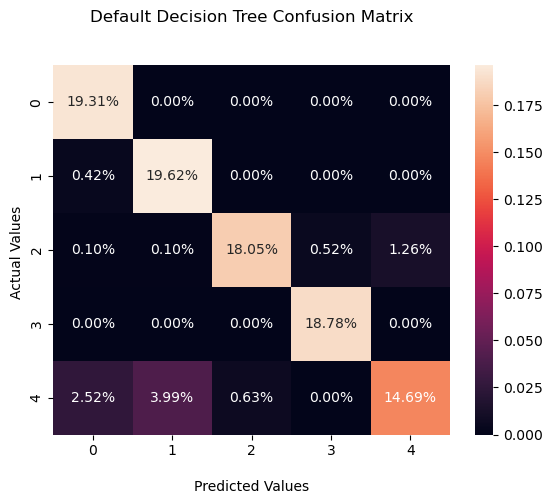

In [126]:
#evaluation of Default Decision Tree: metrics pivot chart
print(classification_report(y_test, y_pred_dt))

print('Accuracy Score : ' + str(round(default_dt_accuracy,3)))
print('Precision Score : ' + str(round(default_dt_precision,3)))
print('Recall Score : ' + str(round(default_dt_recall,3)))
print('F-Score : ' + str(round(default_dt_f1,3)))

cf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
ax = sns.heatmap(cf_matrix_dt/np.sum(cf_matrix_dt), annot=True, fmt='.2%')

ax.set_title('Default Decision Tree Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Decision Tree with hyperparameter tuning**

Important hyperparameters of DecisionTreeClassifier function:
* max_depth
* min_samples_leaf
* criterion

In [127]:
#hyperparameter tuning of decision tree (parameters must be of data type list)
dt_params = {'max_depth': [list(range(1, 21)), None],
          'min_samples_leaf': [2, 5, 10, 20, 50, 100],
          'criterion': ["gini", "entropy", "log_loss"]} 
dt_model_tuning = GridSearchCV(DecisionTreeClassifier(random_state = 0), param_grid = dt_params, n_jobs=-1)
grid_dt_metrics = dt_model_tuning.fit(X_train_transformed, y_train)

#Predict values based on new parameters
y_dt_pred_metrics = grid_dt_metrics.predict(X_test_transformed)

# the best parameters of decision tree
print('Most suitable parameters for Decision Tree: ' + str(grid_dt_metrics.best_params_) + '\n')

#evaluation
tuned_dt_accuracy = accuracy_score(y_test, y_dt_pred_metrics)
tuned_dt_precision = precision_score(y_test, y_dt_pred_metrics, average='macro')
tuned_dt_recall = recall_score(y_test, y_dt_pred_metrics, average='macro')
tuned_dt_f1 = f1_score(y_test, y_dt_pred_metrics, average='macro')

Most suitable parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2}



              precision    recall  f1-score   support

           0       0.84      1.00      0.92       184
           1       0.80      0.96      0.87       191
           2       0.95      0.87      0.91       191
           3       0.96      1.00      0.98       179
           4       0.88      0.61      0.72       208

    accuracy                           0.88       953
   macro avg       0.89      0.89      0.88       953
weighted avg       0.89      0.88      0.87       953

Accuracy Score : 0.88
Precision Score : 0.887
Recall Score : 0.888
F-Score : 0.879


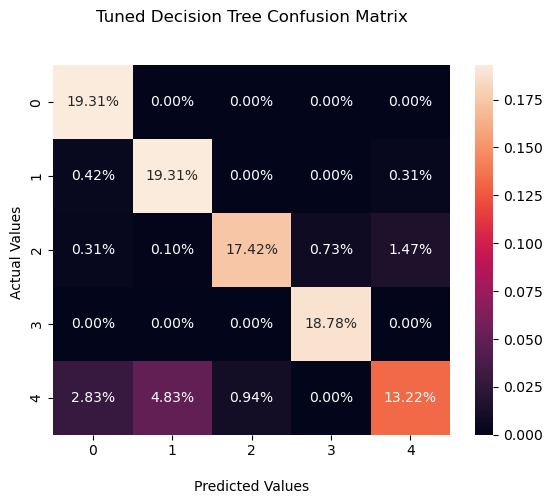

In [128]:
#evaluation of Tuned Decision Tree: metrics pivot chart
print(classification_report(y_test, y_dt_pred_metrics))

print('Accuracy Score : ' + str(round(tuned_dt_accuracy,3)))
print('Precision Score : ' + str(round(tuned_dt_precision,3)))
print('Recall Score : ' + str(round(tuned_dt_recall,3)))
print('F-Score : ' + str(round(tuned_dt_f1,3)))

cf_matrix_dt = confusion_matrix(y_test, y_dt_pred_metrics)
ax = sns.heatmap(cf_matrix_dt/np.sum(cf_matrix_dt), annot=True, fmt='.2%')

ax.set_title('Tuned Decision Tree Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Default Random Forest**

In [129]:
# Create Default Random Forest model
rf = RandomForestClassifier(random_state = 0)
# Create Default Random Forest model
rf.fit(X_train_transformed, y_train)
#Predict the response for test dataset
y_pred_rf = rf.predict(X_test_transformed)

#evaluation
default_rf_accuracy = accuracy_score(y_test, y_pred_rf)
default_rf_precision = precision_score(y_test, y_pred_rf, average='macro')
default_rf_recall = recall_score(y_test, y_pred_rf, average='macro')
default_rf_f1 = f1_score(y_test, y_pred_rf, average='macro')

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       184
           1       0.85      0.98      0.91       191
           2       0.98      0.92      0.95       191
           3       0.98      1.00      0.99       179
           4       0.95      0.75      0.84       208

    accuracy                           0.93       953
   macro avg       0.93      0.93      0.93       953
weighted avg       0.93      0.93      0.92       953

Accuracy Score : 0.925
Precision Score : 0.93
Recall Score : 0.93
F-Score : 0.926


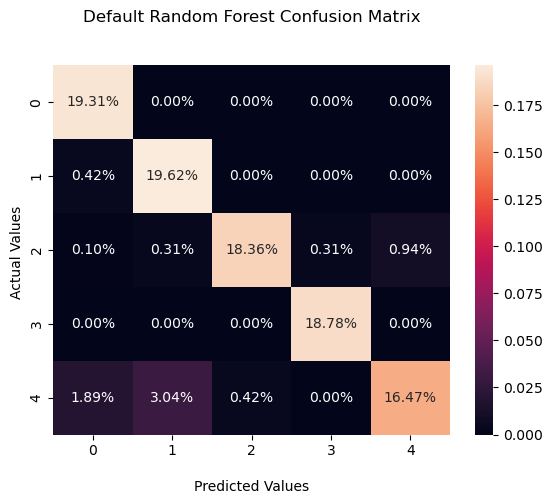

In [130]:
#evaluation of Default Random Forest: metrics pivot chart
print(classification_report(y_test, y_pred_rf))

print('Accuracy Score : ' + str(round(default_rf_accuracy,3)))
print('Precision Score : ' + str(round(default_rf_precision,3)))
print('Recall Score : ' + str(round(default_rf_recall,3)))
print('F-Score : ' + str(round(default_rf_f1,3)))

cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), annot=True, fmt='.2%')

ax.set_title('Default Random Forest Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Random Forest with hyperparameter tuning**

Important hyperparameters of RandomForestClassifier function:
* n_estimators
* criterion
* min_samples_leaf
* min_samples_split
* max_features

In [131]:
#hyperparameter tuning of random forest (parameters must be of data type list)
rf_params = {'n_estimators': [25, 50,70,100,150, 200, 250], 
            'criterion': ['gini', "entropy", "log_loss"], 
            'min_samples_leaf' : list(range(1, 100)), 
            'min_samples_split': [1, 2, 3, 4, 5 ], 
            'max_features': ["sqrt", "log2", None]} 

rf_model_tuning = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = rf_params, n_jobs=-1)
grid_rf_metrics = rf_model_tuning.fit(X_train_transformed, y_train)

#Predict values based on new parameters
y_rf_pred_metrics = grid_rf_metrics.predict(X_test_transformed)

# the best parameters of random forest
print('Most suitable parameters for Random Forest: ' + str(grid_rf_metrics.best_params_) + '\n')

#evaluation
tuned_rf_accuracy = accuracy_score(y_test, y_rf_pred_metrics)
tuned_rf_precision = precision_score(y_test, y_rf_pred_metrics, average='macro')
tuned_rf_recall = recall_score(y_test, y_rf_pred_metrics, average='macro')
tuned_rf_f1 = f1_score(y_test, y_rf_pred_metrics, average='macro')

KeyboardInterrupt: 

In [ ]:
#evaluation of Tuned Random Forest: metrics pivot chart
print(classification_report(y_test, y_rf_pred_metrics))

print('Accuracy Score : ' + str(round(tuned_rf_accuracy,3)))
print('Precision Score : ' + str(round(tuned_rf_precision,3)))
print('Recall Score : ' + str(round(tuned_rf_recall,3)))
print('F-Score : ' + str(round(tuned_rf_f1,3)))

cf_matrix_rf = confusion_matrix(y_test, y_rf_pred_metrics)
ax = sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), annot=True, fmt='.2%')

ax.set_title('Tuned Random Forest Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Default XGBoost**

In [132]:
# Create Default XGBoost model
xgb = XGBClassifier(random_state = 0, eval_metric = "mlogloss")
# Create Default XGBoost model
xgb.fit(X_train_transformed, y_train)
#Predict the response for test dataset
y_pred_xgb = xgb.predict(X_test_transformed)

#evaluation
default_xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
default_xgb_precision = precision_score(y_test, y_pred_xgb, average='macro')
default_xgb_recall = recall_score(y_test, y_pred_xgb, average='macro')
default_xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro')

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       184
           1       0.85      0.96      0.90       191
           2       0.98      0.90      0.94       191
           3       0.98      1.00      0.99       179
           4       0.90      0.71      0.79       208

    accuracy                           0.91       953
   macro avg       0.91      0.91      0.91       953
weighted avg       0.91      0.91      0.90       953

Accuracy Score : 0.908
Precision Score : 0.912
Recall Score : 0.913
F-Score : 0.908


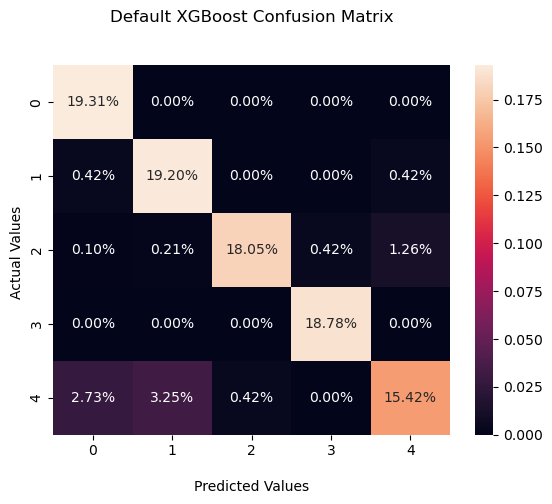

In [133]:
#evaluation of Default XGBoost: metrics pivot chart
print(classification_report(y_test, y_pred_xgb))

print('Accuracy Score : ' + str(round(default_xgb_accuracy,3)))
print('Precision Score : ' + str(round(default_xgb_precision,3)))
print('Recall Score : ' + str(round(default_xgb_recall,3)))
print('F-Score : ' + str(round(default_xgb_f1,3)))

cf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
ax = sns.heatmap(cf_matrix_xgb/np.sum(cf_matrix_xgb), annot=True, fmt='.2%')

ax.set_title('Default XGBoost Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

**XGBoost with hyperparameter tuning**

Important hyperparameters of XGBClassifier function:
* colsample_bytree
* reg_alpha
* reg_lambda
* eval_metric

In [ ]:
#hyperparameter tuning of XGBoost (parameters must be of data type list)
xgb_params = {"colsample_bytree": [ 0.3, 0.5 , 0.8 ], 
            "reg_alpha": [0, 0.5, 1, 5],
            "reg_lambda": [0, 0.5, 1, 5],
            "eval_metric": ["mlogloss", "merror"]} 

xgb_model_tuning = GridSearchCV(XGBClassifier(random_state = 0), param_grid = xgb_params, n_jobs=-1)
grid_xgb_metrics = xgb_model_tuning.fit(X_train_transformed, y_train)

#Predict values based on new parameters
y_xgb_pred_metrics = grid_xgb_metrics.predict(X_test_transformed)

# the best parameters of XGBoost
print('Most suitable parameters for Logistic Regression: ' + str(grid_xgb_metrics.best_params_) + '\n')

#evaluation
tuned_xgb_accuracy = accuracy_score(y_test, y_xgb_pred_metrics)
tuned_xgb_precision = precision_score(y_test, y_xgb_pred_metrics, average='macro')
tuned_xgb_recall = recall_score(y_test, y_xgb_pred_metrics, average='macro')
tuned_xgb_f1 = f1_score(y_test, y_xgb_pred_metrics, average='macro')

Most suitable parameters for Logistic Regression: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'reg_alpha': 0, 'reg_lambda': 0}



              precision    recall  f1-score   support

     drizzle       0.85      0.98      0.91       184
         fog       0.81      0.96      0.88       191
        rain       0.97      0.90      0.93       191
        snow       0.97      1.00      0.99       179
         sun       0.92      0.69      0.79       208

    accuracy                           0.90       953
   macro avg       0.91      0.90      0.90       953
weighted avg       0.91      0.90      0.90       953

Accuracy Score : 0.899
Precision Score : 0.906
Recall Score : 0.905
F-Score : 0.9


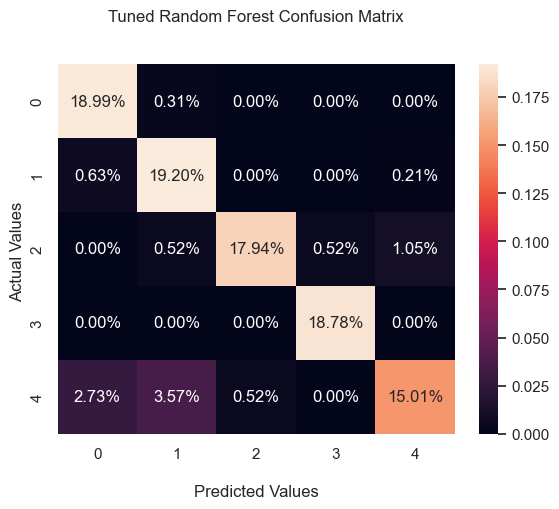

In [ ]:
#evaluation of Tuned Random Forest: metrics pivot chart
print(classification_report(y_test, y_xgb_pred_metrics))

print('Accuracy Score : ' + str(round(tuned_xgb_accuracy,3)))
print('Precision Score : ' + str(round(tuned_xgb_precision,3)))
print('Recall Score : ' + str(round(tuned_xgb_recall,3)))
print('F-Score : ' + str(round(tuned_xgb_f1,3)))

cf_matrix_xgb = confusion_matrix(y_test, y_xgb_pred_metrics)
ax = sns.heatmap(cf_matrix_xgb/np.sum(cf_matrix_xgb), annot=True, fmt='.2%')

ax.set_title('Tuned Random Forest Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1','2','3','4'])
ax.yaxis.set_ticklabels(['0','1','2','3','4'])

## Display the visualization of the Confusion Matrix.
plt.show()

<a id=section-five></a>
# <span style="color:#409996;font-weight:600;font-size:30px;font-style:sans-serif;">5. Results evaluation</span>

In this notebook, we aimed to find the most accurate model with highest accuracy for our dataset of weather prediction.

In [ ]:
#dictionary with all metrics
accuracies = {"Default KNN": default_knn_accuracy, "Tuned KNN":tuned_knn_accuracy, 
              "Default Decision Tree": default_dt_accuracy, "Tuned Decision Tree": tuned_dt_accuracy,
              "Default Random Forest": default_rf_accuracy, "Tuned Random Forest": tuned_rf_accuracy,
              "Default XGBoost": default_xgb_accuracy, "Tuned XGBoost": tuned_xgb_accuracy}
print("The algorithm with highest accuracy: " + max(accuracies, key=accuracies.get))

precisions = {"Default KNN": default_knn_precision, "Tuned KNN":tuned_knn_precision, 
              "Default Decision Tree": default_dt_precision, "Tuned Decision Tree": tuned_dt_precision,
              "Default Random Forest": default_rf_precision, "Tuned Random Forest": tuned_rf_precision,
              "Default XGBoost": default_xgb_precision, "Tuned XGBoost": tuned_xgb_precision}
print("The algorithm with highest precision: " + max(precisions, key=precisions.get))

recalls = {"Default KNN": default_knn_recall, "Tuned KNN":tuned_knn_recall, 
           "Default Decision Tree": default_dt_recall, "Tuned Decision Tree": tuned_dt_recall,
           "Default Random Forest": default_rf_recall, "Tuned Random Forest": tuned_rf_recall,
           "Default XGBoost": default_xgb_recall, "Tuned XGBoost": tuned_xgb_recall}
print("The algorithm with highest recall: " + max(recalls, key=recalls.get))

f1_scores = {"Default KNN": default_knn_f1, "Tuned KNN":tuned_knn_f1, 
             "Default Decision Tree": default_dt_f1, "Tuned Decision Tree": tuned_dt_f1,
             "Default Random Forest": default_rf_f1, "Tuned Random Forest": tuned_rf_f1,
             "Default XGBoost": default_xgb_f1, "Tuned XGBoost": tuned_xgb_f1}
print("The algorithm with highest f1_score: " + max(recalls, key=recalls.get))

NameError: name 'tuned_rf_accuracy' is not defined

In [ ]:
#pivot table with accuracy, precision and recall metrics results
models_keys             = list(accuracies.keys())
accuracy_models_values  = list(accuracies.values())
#precision_models_keys   = list(precisions.keys())
precision_models_values = list(precisions.values())
recall_models_values    = list(recalls.values())
f1_score_models_values  = list(f1_scores.values())

df_models               = pd.DataFrame({"Model":models_keys,
                                       "Accuracy":accuracy_models_values,
                                       "Precision": precision_models_values,
                                       "Recall": recall_models_values,
                                       "F1_Score": f1_score_models_values})
print(df_models)

                   Model  Accuracy  Precision    Recall  F1_Score
0            Default KNN  0.831060   0.847890  0.841222  0.826927
1              Tuned KNN  0.915005   0.921650  0.920660  0.914861
2  Default Decision Tree  0.904512   0.909878  0.910360  0.904023
3    Tuned Decision Tree  0.882476   0.888417  0.889569  0.881035
4  Default Random Forest  0.923400   0.928368  0.928096  0.924026
5        Default XGBoost  0.907660   0.912058  0.913074  0.908060
6          Tuned XGBoost  0.899265   0.906019  0.904920  0.899526


In [ ]:
#preparation for plotting the metrics
accuracy_models_keys    = list(accuracies.keys())
accuracy_models_values  = list(accuracies.values())

df_accuracy             = pd.DataFrame({"Model":accuracy_models_keys,
                                        "Accuracy":accuracy_models_values})

precision_models_keys   = list(precisions.keys())
precision_models_values = list(precisions.values())
df_precision            = pd.DataFrame({"Model": precision_models_keys,
                                        "Precision": precision_models_values})

recall_models_keys      = list(recalls.keys())
recall_models_values    = list(recalls.values())
df_recall               = pd.DataFrame({"Model": recall_models_keys,
                                        "Recall": recall_models_values})

f1_score_models_keys    = list(f1_scores.keys())
f1_score_models_values  = list(f1_scores.values())
df_f1_score             = pd.DataFrame({"Model": f1_score_models_keys,
                                        "F1_score": f1_score_models_values})

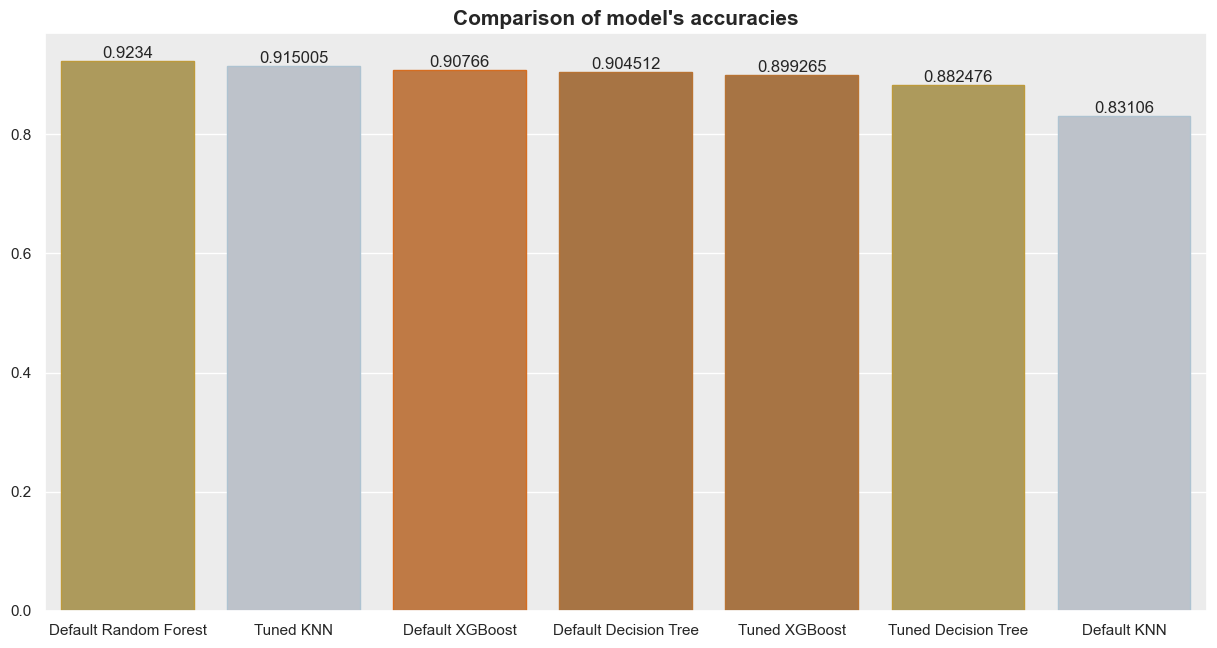

In [ ]:
#model's accuracy evaluation in barplot
olympic_medals_palette = ['#BBA14F','#BBC2CC', '#D37731', '#B87333', '#B87333']
olympic_medals_edge_colors = ['#BD9A3B','#AEC3D1', '#D66D20', '#B87333', '#B87333']
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of plot

plt.figure(figsize = (15,7.5))
ax = sns.barplot(x = list(accuracies.keys()), y = list(accuracies.values()), palette = olympic_medals_palette,  edgecolor = olympic_medals_edge_colors, order=df_accuracy.sort_values('Accuracy', ascending=False).Model)
plt.title(label = "Comparison of model's accuracies", fontsize = 15, fontweight = 'bold', ha = 'center')
ax.bar_label(ax.containers[0], label_type = 'edge', fontsize = 12)

plt.show()

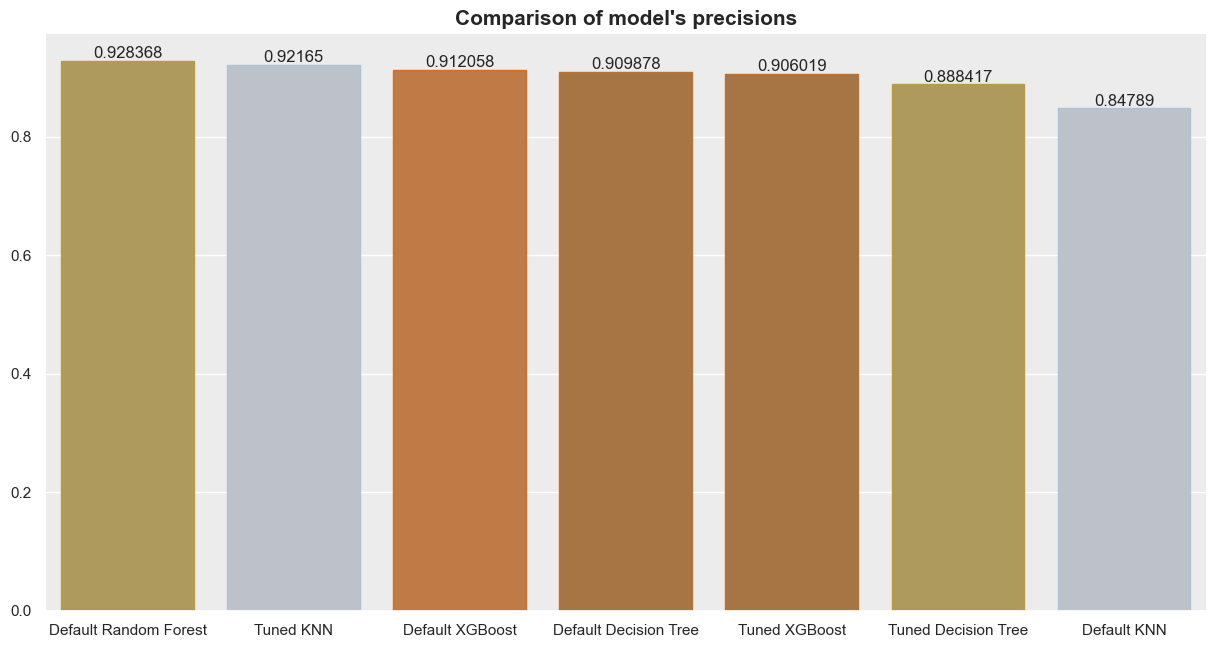

In [ ]:
#model's precision evaluation in barplot
olympic_medals_palette = ['#BBA14F','#BBC2CC', '#D37731', '#B87333', '#B87333']
olympic_medals_edge_colors = ['#BD9A3B','#AEC3D1', '#D66D20', '#B87333', '#B87333']
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of plot

plt.figure(figsize = (15,7.5))
ax = sns.barplot(x = list(precisions.keys()), y = list(precisions.values()), palette = olympic_medals_palette,  edgecolor = olympic_medals_edge_colors, order=df_precision.sort_values("Precision", ascending=False).Model)
plt.title(label = "Comparison of model's precisions", fontsize = 15, fontweight = 'bold', ha = 'center')
ax.bar_label(ax.containers[0], label_type = 'edge', fontsize = 12)

plt.show()

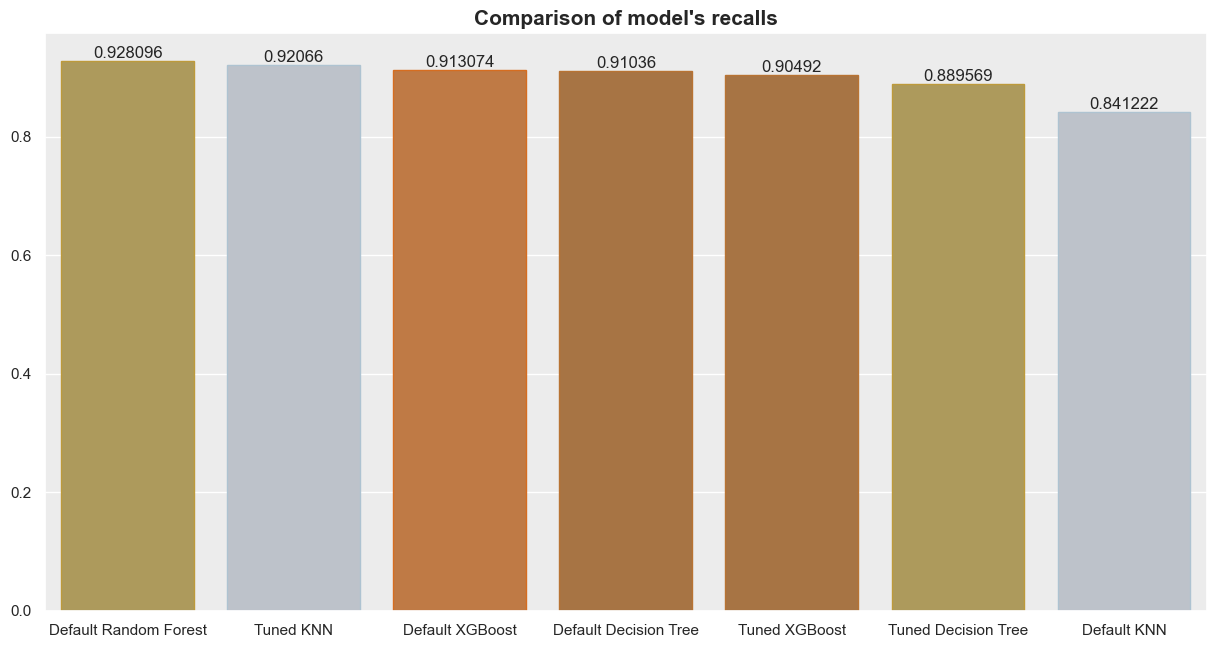

In [ ]:
#model's recall evaluation in barplot
olympic_medals_palette = ['#BBA14F','#BBC2CC', '#D37731', '#B87333', '#B87333']
olympic_medals_edge_colors = ['#BD9A3B','#AEC3D1', '#D66D20', '#B87333', '#B87333']
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of plot

plt.figure(figsize = (15,7.5))
ax = sns.barplot(x = list(recalls.keys()), y = list(recalls.values()), palette = olympic_medals_palette,  edgecolor = olympic_medals_edge_colors, order=df_recall.sort_values("Recall", ascending=False).Model)
plt.title(label = "Comparison of model's recalls", fontsize = 15, fontweight = 'bold', ha = 'center')
ax.bar_label(ax.containers[0], label_type = 'edge', fontsize = 12)

plt.show()

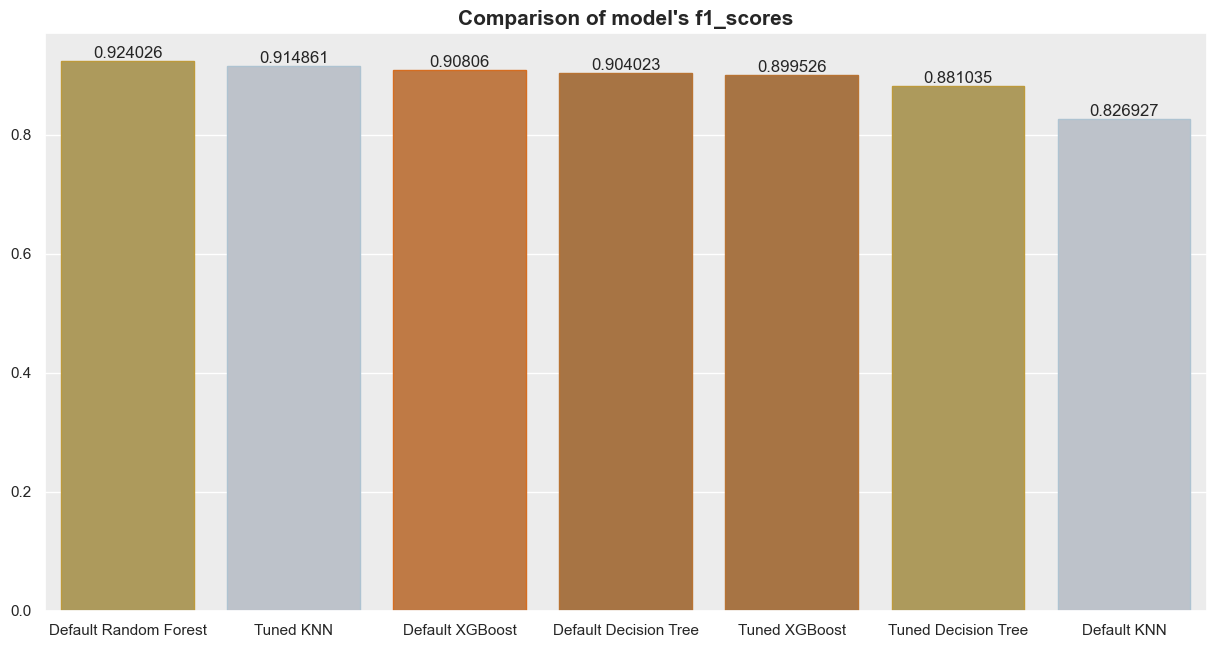

In [ ]:
#model's f1_score evaluation in barplot
olympic_medals_palette = ['#BBA14F','#BBC2CC', '#D37731', '#B87333', '#B87333']
olympic_medals_edge_colors = ['#BD9A3B','#AEC3D1', '#D66D20', '#B87333', '#B87333']
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of plot

plt.figure(figsize = (15,7.5))
ax = sns.barplot(x = list(f1_scores.keys()), y = list(f1_scores.values()), palette = olympic_medals_palette,  edgecolor = olympic_medals_edge_colors, order=df_f1_score.sort_values("F1_score", ascending=False).Model)
plt.title(label = "Comparison of model's f1_scores", fontsize = 15, fontweight = 'bold', ha = 'center')
ax.bar_label(ax.containers[0], label_type = 'edge', fontsize = 12)

plt.show()